In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings 
warnings.filterwarnings("ignore")
from pydataset import data
import prepare

pd.set_option('display.max_rows', 100)

np.random.seed(42)

#### 1. Acquire data from the customers table in the mall_customers database

In [2]:
sql = '''SELECT * FROM customers'''
url = env.get_db_url('mall_customers')

df = pd.read_sql(sql, url)

In [3]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### 2. Summarize the data (include distributions and descriptive statistics)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


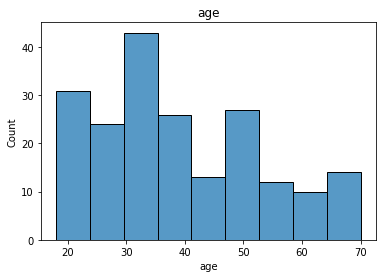

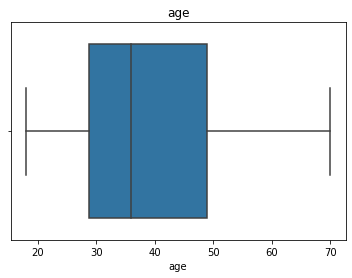

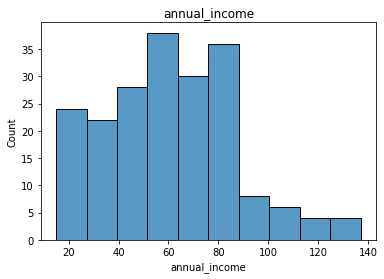

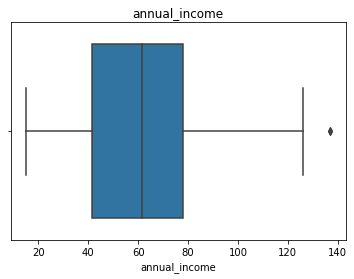

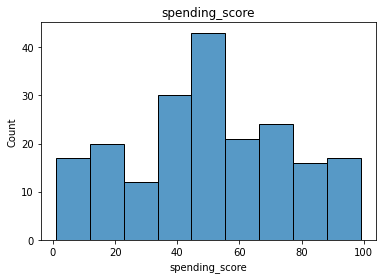

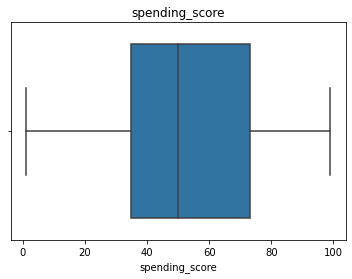

In [6]:
for feature in ['age', 'annual_income', 'spending_score']:
    sns.histplot(df[feature])
    plt.title(feature)
    plt.show()
    sns.boxplot(df[feature])
    plt.title(feature)
    plt.show()

#### 3. Detect outliers using IQR

In [7]:
def detect_outliers(df, k, col):

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles

    iqr = q3 - q1   # calculate interquartile range

    upper_bound = q3 + k * iqr   # get upper bound
    lower_bound = q1 - k * iqr   # get lower bound

    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

In [8]:
age_outliers = detect_outliers(df, 1.5, 'age')
age_outliers

,customer_id,gender,age,annual_income,spending_score


In [9]:
spending_score_outliers = detect_outliers(df, 1.5, 'spending_score')
spending_score_outliers

,customer_id,gender,age,annual_income,spending_score


In [10]:
annual_income_outliers = detect_outliers(df, 1.5, 'annual_income')
annual_income_outliers

,customer_id,gender,age,annual_income,spending_score
198,199,Male,32,137,18
199,200,Male,30,137,83


#### 6. Handle missing values

In [11]:
df.isna().sum()
# there are no missing values

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

#### 5. encode categorical columns using a one hot encoder

In [12]:
def one_hot_encode(df, categorical_columns):
    for col in categorical_columns:
        dummy_df = pd.get_dummies(df[col], 
                                  drop_first=True,
                                  prefix=f'enc_{col}')
        df = pd.concat([df, dummy_df], axis=1)
    return df

In [13]:
categ_cols = ['gender']
df = one_hot_encode(df, categ_cols)
df.head()

,customer_id,gender,age,annual_income,spending_score,enc_gender_Male
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


#### 4. Split data into train, validate, and test

In [14]:
train, test, validate = prepare.train_test_validate_split(df)

train	 n = 112
test	 n = 40
validate n = 48


#### 7. Scaling

In [15]:
def scale_data(train, validate, test, features_to_scale, scaler_type=MinMaxScaler()):
    '''
    This takes in the train, validate, and test dataframes. 

    It then fits a scaler object to the train sample based on the given sample_type, applies that
    scaler to the train, validate, and test samples, and appends the new scaled data to the 
    dataframes as additional columns with the prefix 'scaled_'. 

    train, validate, and test dataframes are returned, in that order. 
    '''
    # establish empty dataframes for storing scaled dataset
    train_scaled = pd.DataFrame(index=train.index)
    validate_scaled = pd.DataFrame(index=validate.index)
    test_scaled = pd.DataFrame(index=test.index)
    # screate and fit the scaler
    scaler = scaler_type.fit(train[features_to_scale])
    # adding scaled features to scaled dataframes
    train_scaled[features_to_scale] = scaler.transform(train[features_to_scale])
    validate_scaled[features_to_scale] = scaler.transform(validate[features_to_scale])
    test_scaled[features_to_scale] = scaler.transform(test[features_to_scale])
    # add 'scaled' prefix to columns
    for feature in features_to_scale:
        train_scaled = train_scaled.rename(columns={feature: f'scaled_{feature}'})
        validate_scaled = validate_scaled.rename(columns={feature: f'scaled_{feature}'})
        test_scaled = test_scaled.rename(columns={feature: f'scaled_{feature}'})
    # concat scaled feature columns to original train, validate, test df's
    train = pd.concat([train, train_scaled], axis=1)
    validate = pd.concat([validate, validate_scaled], axis=1)
    test = pd.concat([test, test_scaled], axis=1)

    return train, validate, test

In [16]:
train, validate, test = scale_data(train, validate, test, 
                                   ['age', 'annual_income', 'spending_score'])

In [17]:
train.head()

,customer_id,gender,age,annual_income,spending_score,enc_gender_Male,scaled_age,scaled_annual_income,scaled_spending_score
130,131,Male,47,71,9,1,0.557692,0.459016,0.081633
62,63,Female,67,47,52,0,0.942308,0.262295,0.520408
13,14,Female,24,20,77,0,0.115385,0.040984,0.775510
173,174,Male,36,87,92,1,0.346154,0.590164,0.928571
144,145,Male,25,77,12,1,0.134615,0.508197,0.112245
